In [1]:
import re
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm

import folium
from folium import plugins
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString, box
import networkx as nx
import gurobipy as gb

## Load data

In [2]:
segments = pd.read_csv("segments.csv")
stops = pd.read_csv("stops.csv")

segments[["route_id", "start_stop_id", "end_stop_id"]] = segments[
    ["route_id", "start_stop_id", "end_stop_id"]
].astype(str)


def get_segment_stops(segment_df, route_id, direction_id=0):
    segment_distance = segment_df.query(
        "route_id == @route_id & direction_id == @direction_id"
    )

    stops_in_route = stops[
        stops["stop_id"].isin(
            list(
                set(
                    segment_distance[["start_stop_id", "end_stop_id"]].values.reshape(
                        -1
                    )
                )
            )
        )
    ]

    return segment_distance, stops_in_route

In [3]:
### Get stops on route
routes = ["24", "51", "67", "18", "33", "45", "80"]
route_details = {}

for r in routes:
    detail = get_segment_stops(segments, r, 0)

    route_details[r] = {}
    route_details[r]["segment"] = detail[0]
    route_details[r]["stops"] = detail[1]

stops_df = pd.concat([v["stops"] for k, v in route_details.items()]).drop_duplicates()

print(f"Number of total stops in routes: {len(stops_df)}")

stops_df["geometry"] = stops_df.apply(
    lambda x: Point((float(x.stop_lon), float(x.stop_lat))), axis=1
)

stops_df_gpd = gpd.GeoDataFrame(stops_df, geometry="geometry").drop(
    columns=["location_type", "parent_station", "wheelchair_boarding"]
)

stops_df_gpd.head()

Number of total stops in routes: 326


,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry
1769,51241,51241,Station Villa-Maria,45.479704,-73.619643,https://www.stm.info/fr/recherche#stq=51241,POINT (-73.61964 45.47970)
1806,51281,51281,Décarie / Duquette,45.478389,-73.618050,https://www.stm.info/fr/recherche#stq=51281,POINT (-73.61805 45.47839)
1848,51326,51326,Décarie / Notre-Dame-de-Grâce,45.477244,-73.615513,https://www.stm.info/fr/recherche#stq=51326,POINT (-73.61551 45.47724)
1891,51372,51372,Décarie / Côte-Saint-Antoine,45.476312,-73.613443,https://www.stm.info/fr/recherche#stq=51372,POINT (-73.61344 45.47631)
1976,51462,51462,Décarie / Sherbrooke,45.474535,-73.609490,https://www.stm.info/fr/recherche#stq=51462,POINT (-73.60949 45.47454)


### Take a random sample of stops

In [4]:
random_stops_df_gpd = stops_df_gpd.sample(frac=0.1, random_state=2)
random_stops_df_gpd.head()

# Add a depot stop to the dataframe
depot = pd.DataFrame(
    {
        "stop_id": ["0"],
        "stop_name": ["Depot"],
        "stop_lat": [45.5048542],
        "stop_lon": [-73.5691235],
        "stop_code": 0.0,
    }
)

depot["geometry"] = Point((float(depot.stop_lon), float(depot.stop_lat)))

random_stops_df_gpd = pd.concat([depot, random_stops_df_gpd]).reset_index(drop=True)

print(f"Number of stops in sample: {len(random_stops_df_gpd)}")

random_stops_df_gpd

Number of stops in sample: 34


,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
0,0,Depot,45.504854,-73.569124,0.0,POINT (-73.5691235 45.5048542),NaN
1,51880,du Parc / du Mont-Royal,45.516693,-73.588818,51880.0,POINT (-73.588818 45.516693),https://www.stm.info/fr/recherche#stq=51880
2,51671,du Parc / Fairmount,45.520366,-73.597286,51671.0,POINT (-73.597286 45.520366),https://www.stm.info/fr/recherche#stq=51671
3,52009,Sherbrooke / Chomedey,45.492614,-73.585807,52009.0,POINT (-73.585807 45.492614),https://www.stm.info/fr/recherche#stq=52009
4,51285,du Parc / No 6659,45.528206,-73.615501,51285.0,POINT (-73.615501 45.528206),https://www.stm.info/fr/recherche#stq=51285
5,53825,Saint-Michel / William-Tremblay,45.547751,-73.561700,53825.0,POINT (-73.5617 45.547751),https://www.stm.info/fr/recherche#stq=53825
6,61839,Haig / Hochelaga,45.582393,-73.530154,61839.0,POINT (-73.530154 45.582393),https://www.stm.info/fr/recherche#stq=61839
7,62057,Papineau / Jacques-Casault,45.555471,-73.623566,62057.0,POINT (-73.623566 45.555471),https://www.stm.info/fr/recherche#stq=62057
8,51086,Queen-Mary / Lemieux,45.486787,-73.626289,51086.0,POINT (-73.626289 45.486787),https://www.stm.info/fr/recherche#stq=51086
9,51551,Beaubien / Saint-Hubert,45.535993,-73.603111,51551.0,POINT (-73.603111 45.535993),https://www.stm.info/fr/recherche#stq=51551


## Calculate distance matrix

In [5]:
# G = ox.graph_from_place("Montreal, Canada", network_type="drive")
G = ox.load_graphml("montreal_drive.graphml")

In [6]:
print(f"Number of stops: {len(random_stops_df_gpd)}")
distance_matrix = pd.read_json("distance_matrix.json")

distance_matrix.columns = distance_matrix.columns.astype(str)
distance_matrix.index = distance_matrix.index.astype(str)

Number of stops: 34


In [7]:
# Run if stops change

# print(f"Number of stops: {len(random_stops_df_gpd)}")

# distance_matrix = np.zeros((len(random_stops_df_gpd), len(random_stops_df_gpd)))
# for i, stop1 in enumerate(random_stops_df_gpd.itertuples()):
#     print(f"Calculating distance for stop {i}")
#     for j in range(i + 1, len(random_stops_df_gpd)):
#         stop2 = random_stops_df_gpd.iloc[j]

#         origin = ox.nearest_nodes(G, stop1.stop_lon, stop1.stop_lat)
#         destination = ox.nearest_nodes(G, stop2.stop_lon, stop2.stop_lat)

#         try:
#             distance = nx.shortest_path_length(G, origin, destination, weight="length")
#         except nx.NetworkXNoPath:
#             distance = np.Inf

#         distance_matrix[i, j] = distance
#         distance_matrix[j, i] = distance

#     print("-" * 100)

# distance_matrix = pd.DataFrame(
#     distance_matrix / 1000,
#     columns=random_stops_df_gpd.stop_id,
#     index=random_stops_df_gpd.stop_id,
# )

# distance_matrix.to_json("distance_matrix.json")

## Find disaster nodes

In [8]:
disaster_area = box(minx=-73.50826, miny=45.57889, maxx=-73.53963, maxy=45.60587)

random_stops_df_gpd = gpd.GeoDataFrame(random_stops_df_gpd, geometry="geometry")

stops_in_disaster_area = random_stops_df_gpd[
    random_stops_df_gpd.within(disaster_area)
]

stops_in_disaster_area

,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
6,61839,Haig / Hochelaga,45.582393,-73.530154,61839.0,POINT (-73.53015 45.58239),https://www.stm.info/fr/recherche#stq=61839
13,53242,Sherbrooke / Lepailleur,45.595202,-73.535636,53242.0,POINT (-73.53564 45.59520),https://www.stm.info/fr/recherche#stq=53242
23,53478,Notre-Dame / No 7200,45.582345,-73.510771,53478.0,POINT (-73.51077 45.58234),https://www.stm.info/fr/recherche#stq=53478
28,54311,Hector-Barsalou / De Boucherville,45.585019,-73.510997,54311.0,POINT (-73.51100 45.58502),https://www.stm.info/fr/recherche#stq=54311


## View stops in sample

In [9]:
stops_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(stops_map)

for stop in random_stops_df_gpd.itertuples():
    folium.CircleMarker(
        location=[stop.stop_lat, stop.stop_lon],
        radius=5,
        color="#3186cc",
        fill=True,
        fill_opacity=1,
        fill_color="#3186cc",
        tooltip=f"{stop.stop_name} ({stop.stop_id})",
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(stops_map)

folium.plugins.Fullscreen(position="topright").add_to(stops_map)
folium.plugins.MousePosition(position="topright").add_to(stops_map)

stops_map

## Capacity vehicle routing problem

### Parameters

In [10]:
rng = np.random.default_rng(2)

distance_matrix_model = distance_matrix.drop(
    columns=stops_in_disaster_area.stop_id, index=stops_in_disaster_area.stop_id
)

stops = list(distance_matrix_model.columns)
num_stops = len(stops)

demand = {stop: rng.integers(5, 10) for stop in stops}
demand[stops[0]] = 0

num_buses = 10
BUS_CAPACITY = 100

print(f"Total demand: {sum(demand.values())}")
print(f"Total capacity: {num_buses * BUS_CAPACITY}")

Total demand: 202
Total capacity: 1000


### Model

In [11]:
# ----------------------------------------------------------------------------------------------
# Model

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 60 * 2

# ----------------------------------------------------------------------------------------------
# Decision Variables

x = model.addVars(
    stops,
    stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (bus {k})" for i in stops for j in stops for k in range(num_buses)
    ),
)

u = model.addVars(
    stops,
    vtype=gb.GRB.INTEGER,
    name=(f"Load at Stop {i}" for i in stops),
)

# ----------------------------------------------------------------------------------------------
# Objective Function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# ----------------------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in stops) == gb.quicksum(x[i, j, k] for j in stops)
        for i in stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in stops for k in range(num_buses)) == 1
        for j in stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[stops[0], j, k] for j in stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(demand[j] * x[i, j, k] for j in stops[1:] for i in stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# No travel between same node
model.addConstrs(
    (x[i, i, k] == 0 for i in stops for k in range(num_buses)),
    name="No same node",
)

# Subtour elimination constraints
model.addConstrs(
    (
        u[j] - u[i] >= demand[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in stops[1:]
        for j in stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= demand[i] for i in stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in stops[1:]),
    name="Upper bound for u",
)

# ----------------------------------------------------------------------------------------------
# Solve model
model.update()
model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-30
Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 8827 rows, 9030 columns and 59808 nonzeros
Model fingerprint: 0x2646ebec
Variable types: 0 continuous, 9030 integer (9000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 358 rows and 301 columns
Presolve time: 0.11s
Presolved: 8469 rows, 8729 columns, 58870 nonzeros
Variable types: 0 continuous, 8729 integer (8700 binary)

Root relaxation: objective 4.124521e+01, 311 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Obj

In [12]:
print(f"Objective value: {model.objVal:.2f} km")

# Distance by bus
distance_bus = pd.DataFrame(
    {
        "bus": k,
        "distance": sum(
            distance_matrix_model.loc[i, j] * x[i, j, k].x for i in stops for j in stops
        ),
    }
    for k in range(num_buses)
)

distance_bus = distance_bus[distance_bus["distance"] > 0].reset_index(drop=True)

display(distance_bus)

Objective value: 75.03 km


,bus,distance
0,4,17.567758
1,5,16.820140
2,6,40.643765


### Optimal solution routes

In [13]:
# Bus path
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in stops:
        for j in stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# Convert to df with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

paths = {}

grouped = bus_path_df.groupby("bus")

# Iterate over each bus group
for bus, group in grouped:
    sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
        drop=True
    )
    path = ["0"]  # Initialize the path with the depot

    # Start with the first stop after the depot
    current_stop = sorted_group.loc[
        sorted_group["start_stop"] == "0", "end_stop"
    ].values[0]
    path.append(current_stop)

    # Follow the chain of stops
    while True:
        # Find the next stop where the current stop is the start stop
        next_stop = sorted_group.loc[
            sorted_group["start_stop"] == current_stop, "end_stop"
        ].values
        if not next_stop:
            break  # If there is no next stop, we've completed the path
        next_stop = next_stop[0]

        # Add the next stop to the path and set it as the current stop
        if next_stop == "0":
            break  # If the next stop is the depot, we've completed the path
        path.append(next_stop)
        current_stop = next_stop

    # Store the path for this bus
    paths[bus] = path

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)

bus_path_df["demand"] = bus_path_df["end_stop"].map(demand)

bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

print(f"Number of buses used: {bus_path_df.bus.nunique()}")

bus_path_df

Number of buses used: 3


,bus,start_stop,end_stop,distance,step,stop_id,stop_name,geometry,demand,step_demand
0,4,0,51880,2.215283,0,51880,du Parc / du Mont-Royal,POINT (-73.58882 45.51669),6,6
1,4,51880,56205,1.420300,1,56205,Côte-Sainte-Catherine / Stuart,POINT (-73.60653 45.51520),7,13
2,4,56205,56196,0.358753,2,56196,Côte-Sainte-Catherine / Courcelette,POINT (-73.61093 45.51408),9,22
3,4,56196,51167,2.199287,3,51167,Decelles / Édouard-Montpetit,POINT (-73.62216 45.49916),5,27
4,4,51167,51146,1.371110,4,51146,Queen-Mary / Roslyn,POINT (-73.62370 45.48968),9,36
5,4,51146,51086,0.372831,5,51086,Queen-Mary / Lemieux,POINT (-73.62629 45.48679),5,41
6,4,51086,51372,2.046165,6,51372,Décarie / Côte-Saint-Antoine,POINT (-73.61344 45.47631),5,46
7,4,51372,52009,5.478294,7,52009,Sherbrooke / Chomedey,POINT (-73.58581 45.49261),6,52
8,4,52009,0,2.105735,8,0,Depot,POINT (-73.56912 45.50485),0,52
9,5,0,53825,5.284871,0,53825,Saint-Michel / William-Tremblay,POINT (-73.56170 45.54775),9,9


In [14]:
for route in paths:
    print(f"Route {route +  1}: {' -> '.join(paths[route])} -> 0")

Route 5: 0 -> 51880 -> 56205 -> 56196 -> 51167 -> 51146 -> 51086 -> 51372 -> 52009 -> 0
Route 6: 0 -> 53825 -> 52239 -> 60634 -> 51983 -> 51943 -> 51695 -> 51629 -> 51551 -> 51671 -> 51712 -> 0
Route 7: 0 -> 52720 -> 52657 -> 52748 -> 54511 -> 55294 -> 55218 -> 55046 -> 54395 -> 62057 -> 51093 -> 51285 -> 0


Bus 5:


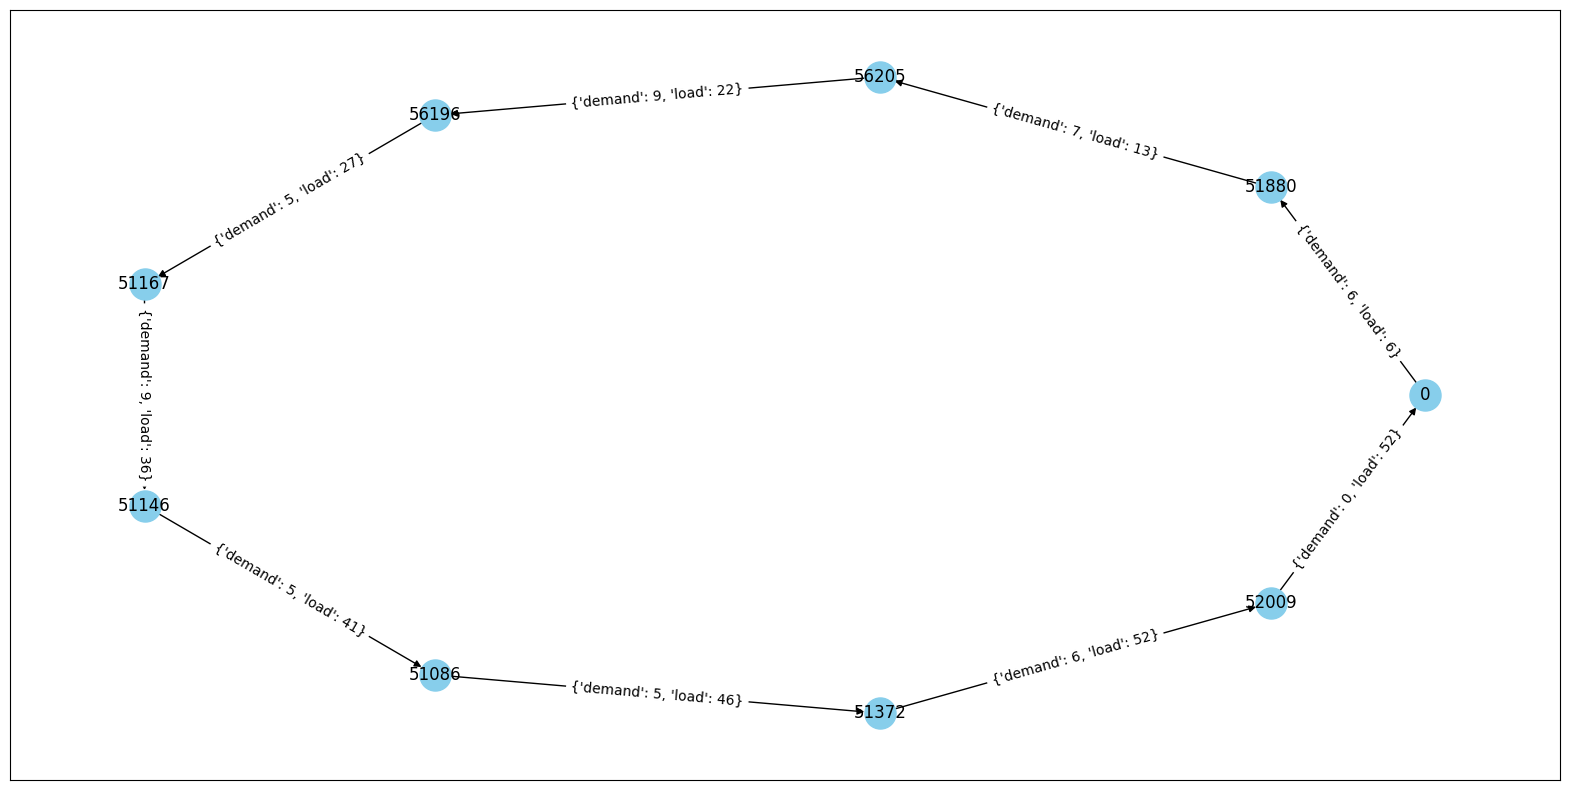



Bus 6:


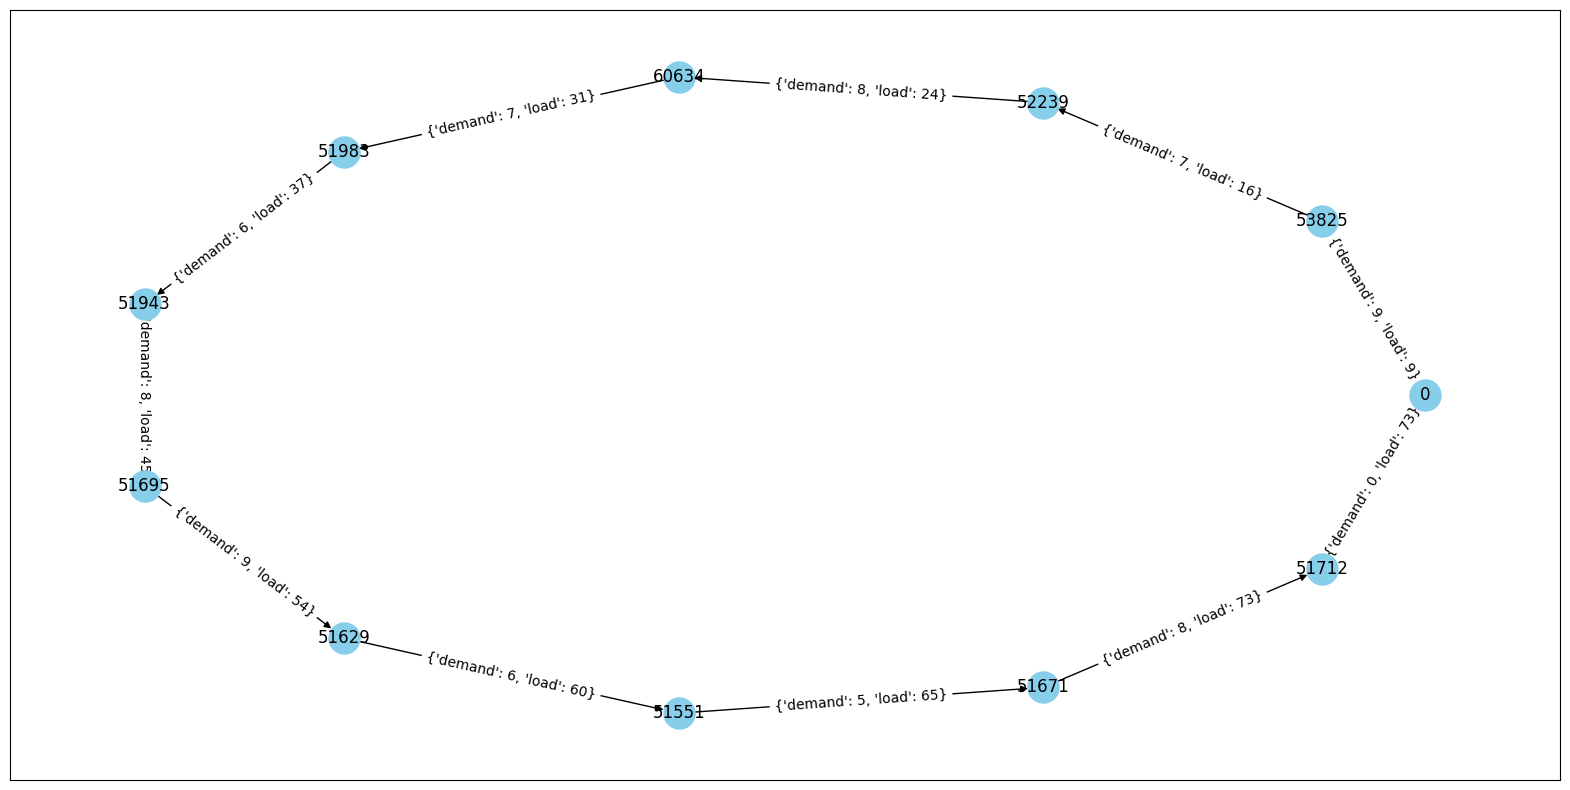



Bus 7:


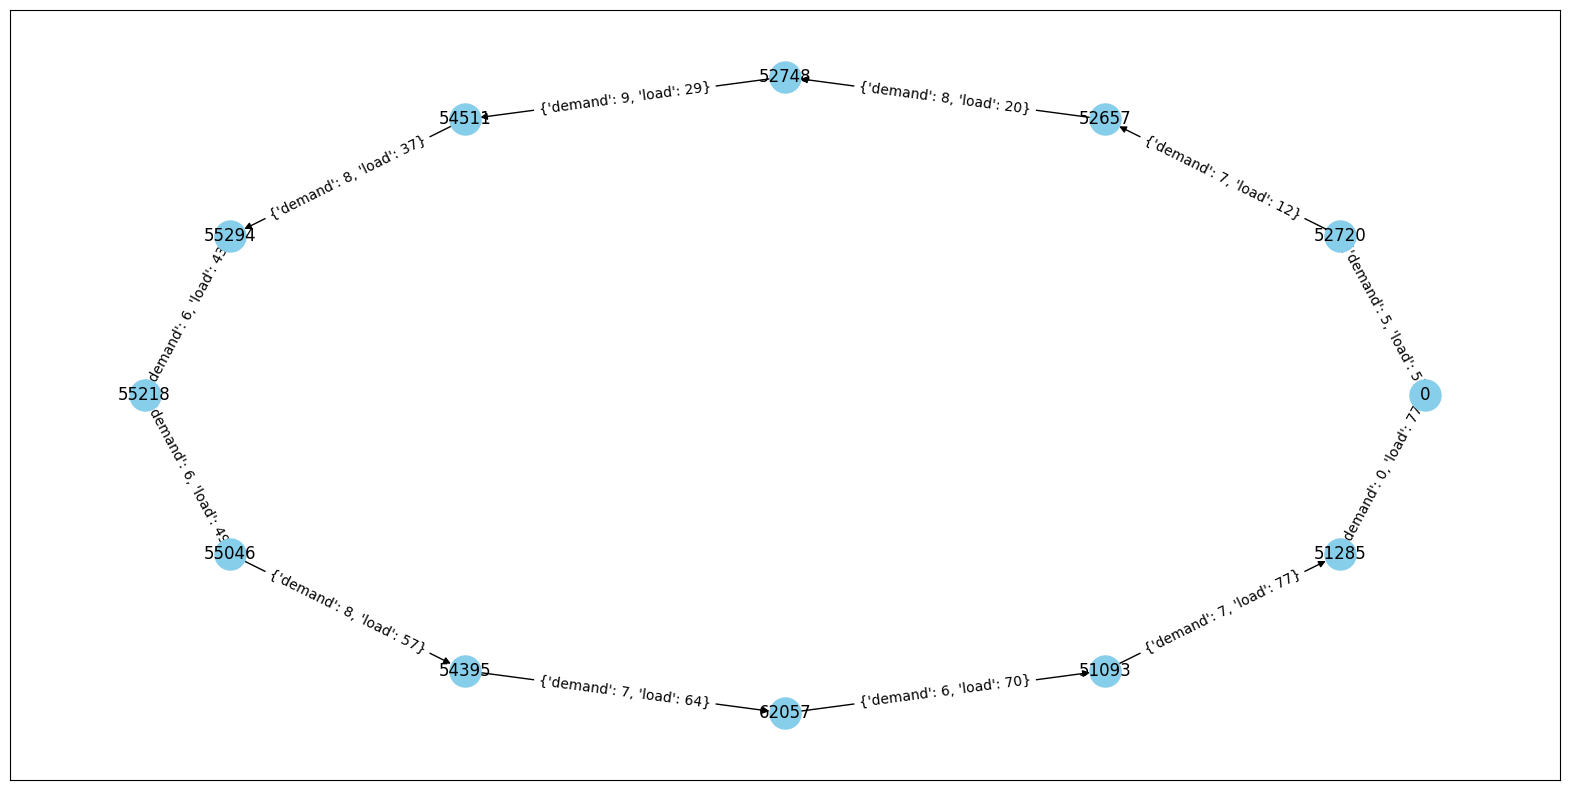

In [15]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus + 1}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(20, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={"demand": segment.demand, "load": segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=nx.get_edge_attributes(g, "demands")
    )

    plt.show()

    print("\n")

In [16]:
bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index()

,bus,demand
0,4,52
1,5,73
2,6,77


In [17]:
routes_gdf = (
    gpd.GeoDataFrame(bus_path_df.groupby("bus")["geometry"].apply(list))
    .rename(columns={"points": "geometry"})
    .reset_index()
)

# add depot to each geometry
routes_gdf["points"] = routes_gdf.apply(
    lambda x: [Point((float(depot.stop_lon), float(depot.stop_lat)))] + x.geometry,
    axis=1,
)

routes_gdf["geometry"] = routes_gdf["points"].apply(LineString)
routes_gdf.drop(columns=["points"], inplace=True)

routes_gdf = routes_gdf.merge(
    bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index(),
    on="bus",
)

routes_gdf = gpd.GeoDataFrame(routes_gdf, geometry="geometry")
routes_gdf.crs = "EPSG:4326"

routes_gdf

,bus,geometry,demand
0,4,"LINESTRING (-73.56912 45.50485, -73.58882 45.5...",52
1,5,"LINESTRING (-73.56912 45.50485, -73.56170 45.5...",73
2,6,"LINESTRING (-73.56912 45.50485, -73.56303 45.5...",77


In [21]:
colormap = cm.get_cmap("tab10")

route_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(route_map)

for stop in bus_path_df.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="#3186cc",
        fill=True,
        fill_opacity=1,
        fill_color="#3186cc",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        <br>
        Step: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step'].values[0] + 1}
        <br>
        Demand: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['demand'].values[0]}
        <br>
        Load: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step_demand'].values[0]}
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)

for stop in stops_in_disaster_area.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="#3186cc",
        fill=True,
        fill_opacity=1,
        fill_color="#3186cc",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)


for route in routes_gdf.itertuples():
    route_layer = folium.FeatureGroup(name=f"Route {route.Index + 1}")

    folium.PolyLine(
        locations=[(p[1], p[0]) for p in route.geometry.coords],
        color=mcolors.rgb2hex(colormap.colors[route.Index]),
        weight=3,
        opacity=0.8,
        tooltip=f"Route {route.Index + 1}",
        popup=f"""
        <div>
            <h5>Route {route.Index + 1}</h5>
            <h5>Total demand: {route.demand}</h5>
        </div>
        """,
    ).add_to(route_layer)

    route_layer.add_to(route_map)

folium.plugins.Fullscreen(position="topright").add_to(route_map)
folium.plugins.MousePosition(position="topright").add_to(route_map)
folium.LayerControl().add_to(route_map)

route_map